In [1]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append('../python')
from functions import *
from models import *
import tensorflow as tf
from livelossplot import PlotLossesKeras
os.environ["CUDA_VISIBLE_DEVICES"] = "1" # pick a number < 4 on ML4HEP; < 3 on Voltan 
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)

# Load data

In [2]:
stream = "gd1_tail"
df, file = load_file(stream = stream)

In [3]:
df = df.drop_duplicates(subset=['α','δ','μ_α','μ_δ','color','mag'])
weight=1 
df["weight"] = np.where(df['stream']==True, weight, 1)

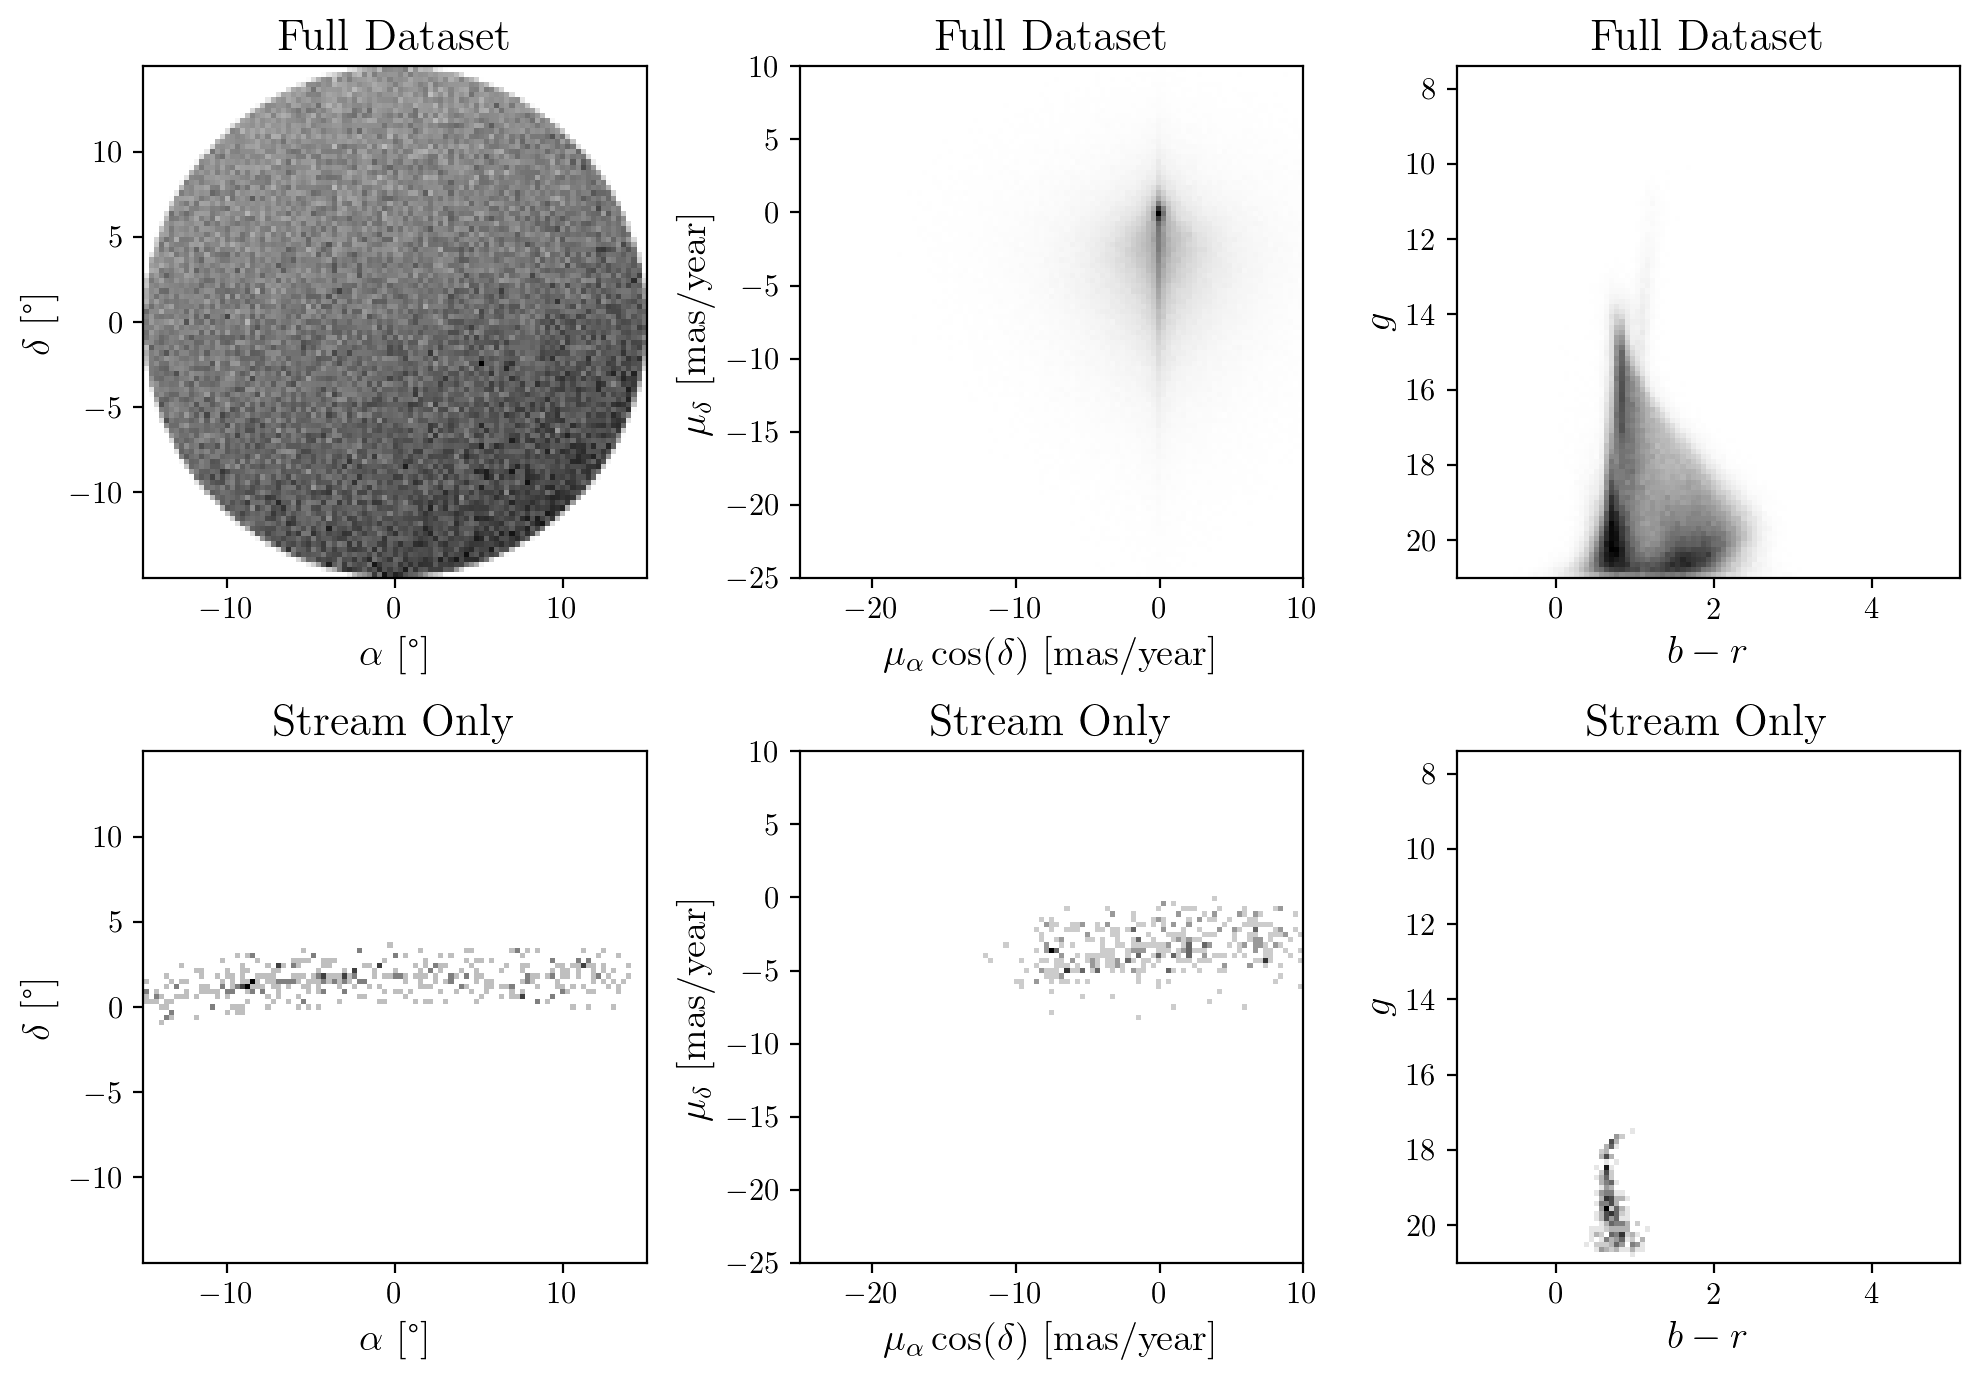

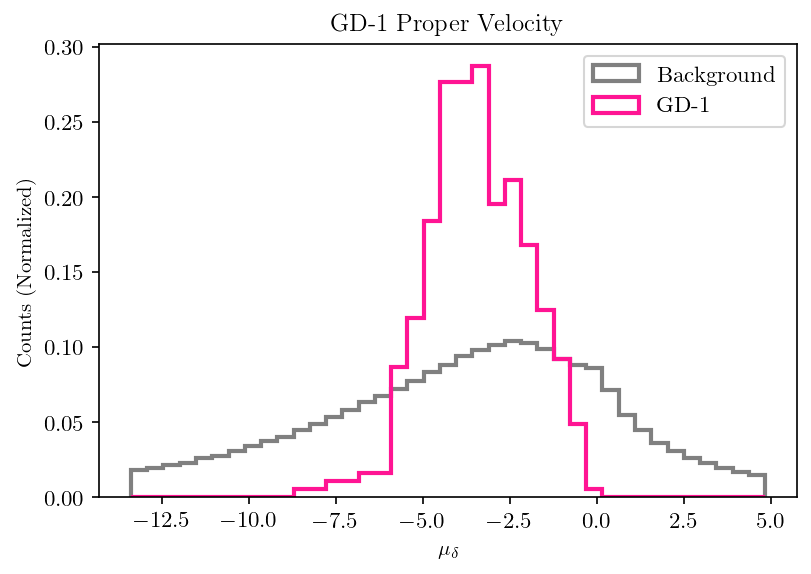

In [4]:
save_folder = "../trained_models/gd1_tail_nfold10"
visualize_stream(df, save_folder=save_folder)

Sideband region: [-7.0,-3.0]
Signal region: [-6.0,-3.1]


/clusterfs/ml4hep/mpettee/GaiaCWoLa/notebooks/../python/functions.py:265: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_slice['label'] = np.where(((df_slice.μ_δ > sr_min) & (df_slice.μ_δ < sr_max)), 1, 0)


Total counts: SR = 128,211, SB = 38,237
Signal region has 230 stream and 127,981 bkg events (0.18%).
Sideband region has 14 stream and 38,223 bkg events (0.04%).
f_sig = 4.9X f_sideband.


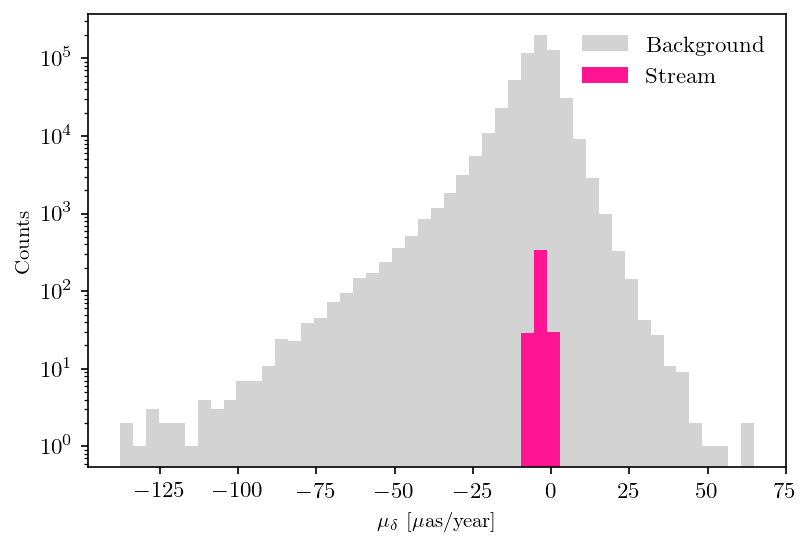

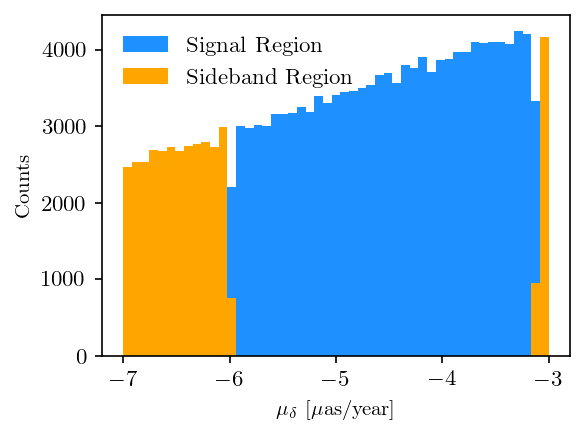

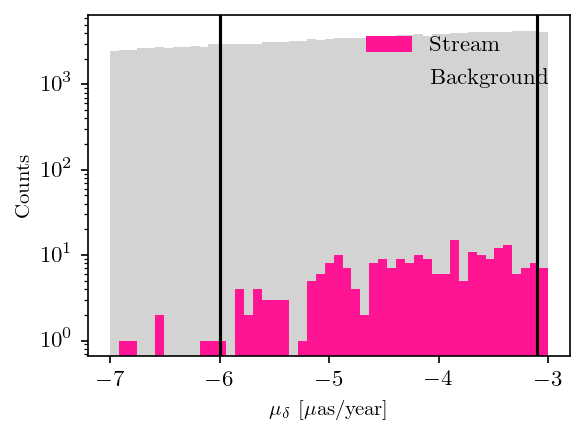

In [5]:
df = signal_sideband(df, stream = stream)

# Train

In [6]:
tf.keras.backend.clear_session()

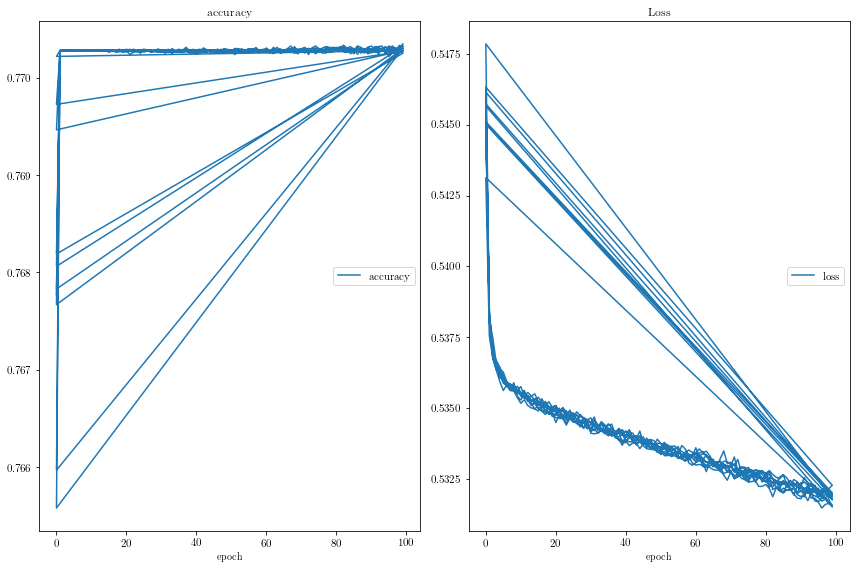

accuracy
	accuracy         	 (min:    0.766, max:    0.770, cur:    0.770)
Loss
	loss             	 (min:    0.531, max:    0.548, cur:    0.532)
521/521 [==============================] - 0s 818us/step


/clusterfs/ml4hep/mpettee/GaiaCWoLa/notebooks/../python/models.py:112: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test["nn_score"] = model.predict(x_test)


Top 10 stars: Purity = 0.0% 
Top 20 stars: Purity = 0.0% 
Top 25 stars: Purity = 0.0% 
Top 50 stars: Purity = 4.0% 
Top 100 stars: Purity = 4.0% 
Fold purities: [2.0, 4.0, 0, 0, 0, 8.0, 0, 0, 0, 4.0]
Average purity = 1.8
Best k-fold = 5, with a purity of 8.00%.
Loading weights from k-fold 5...
Top 10 stars: Purity = 20.0% 
Top 20 stars: Purity = 15.0% 
Top 25 stars: Purity = 12.0% 
Top 50 stars: Purity = 8.0% 
Top 100 stars: Purity = 7.0% 
Top 10 stars: Purity = 20.0% 
Top 20 stars: Purity = 20.0% 
Top 25 stars: Purity = 24.0% 
Top 50 stars: Purity = 12.0% 
Top 100 stars: Purity = 7.0% 


Loop: 100%|██████████| 1/1 [16:59<00:00, 1019.95s/it]


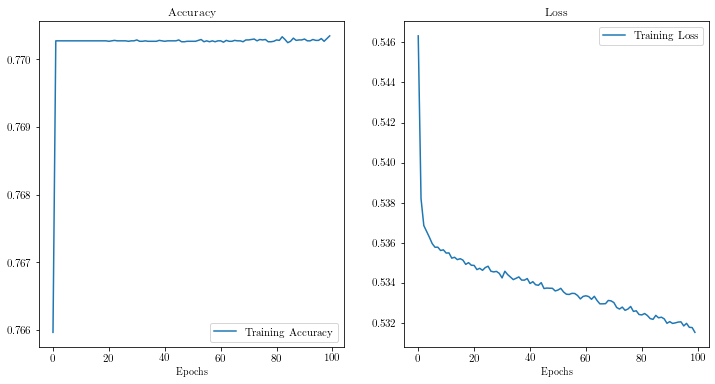

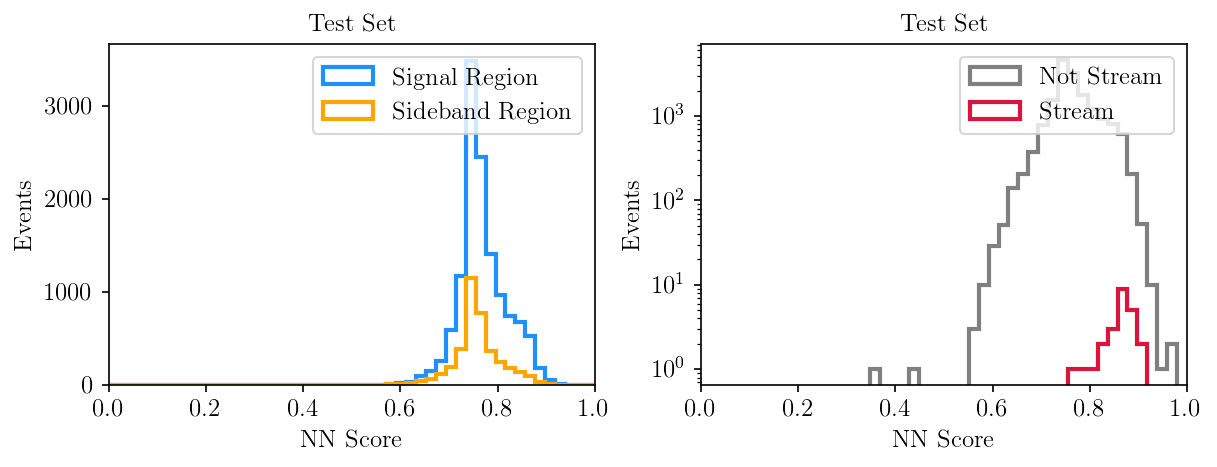

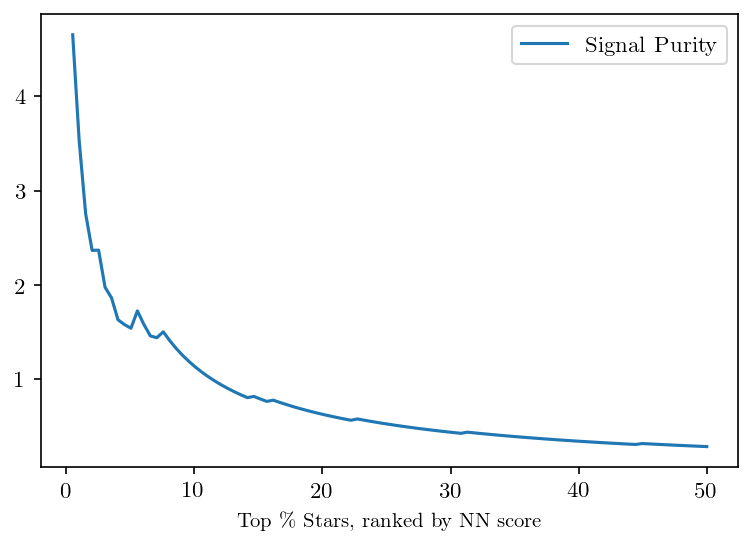

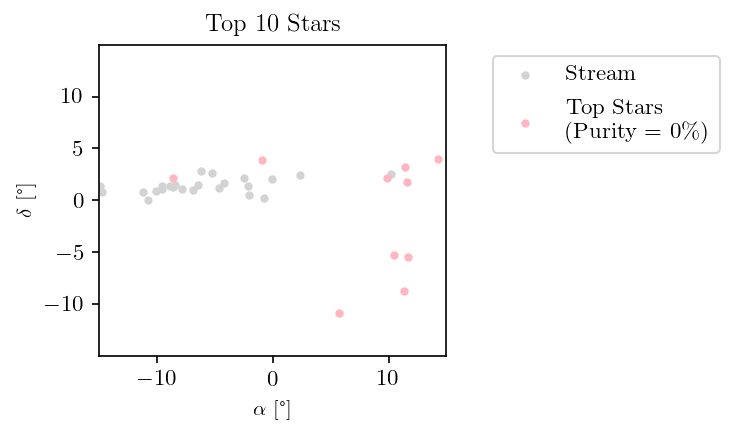

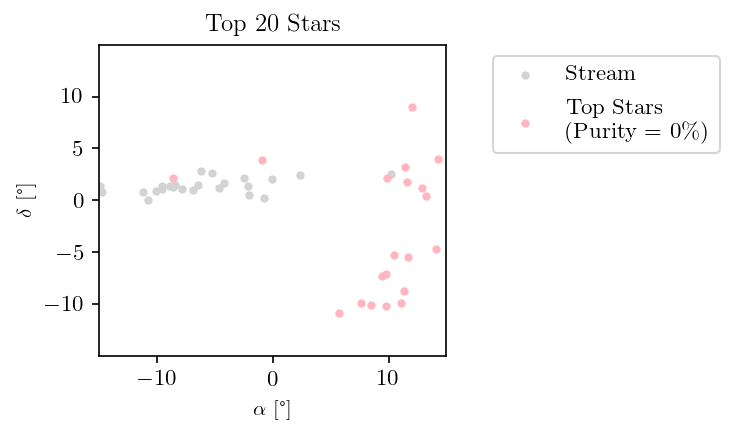

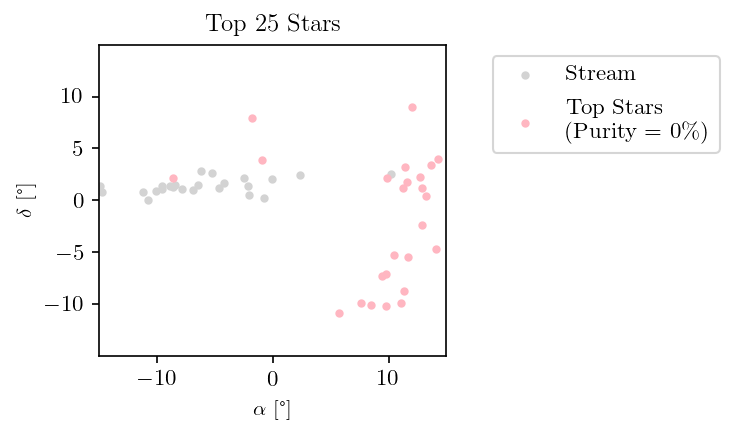

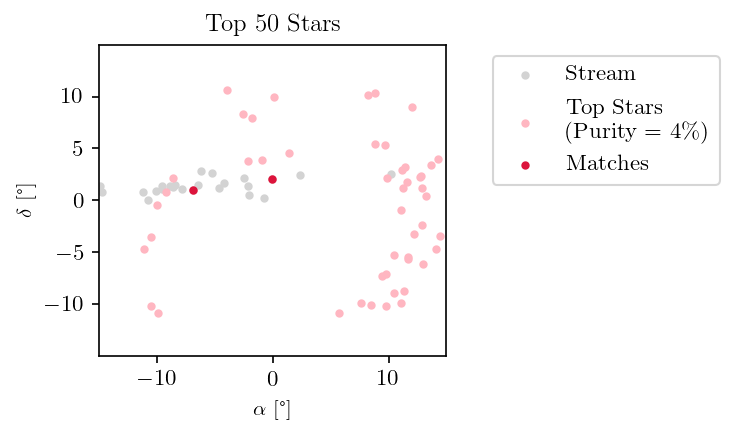

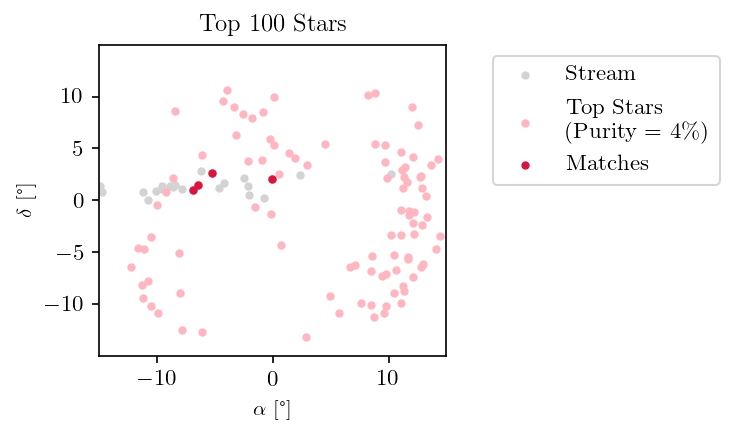

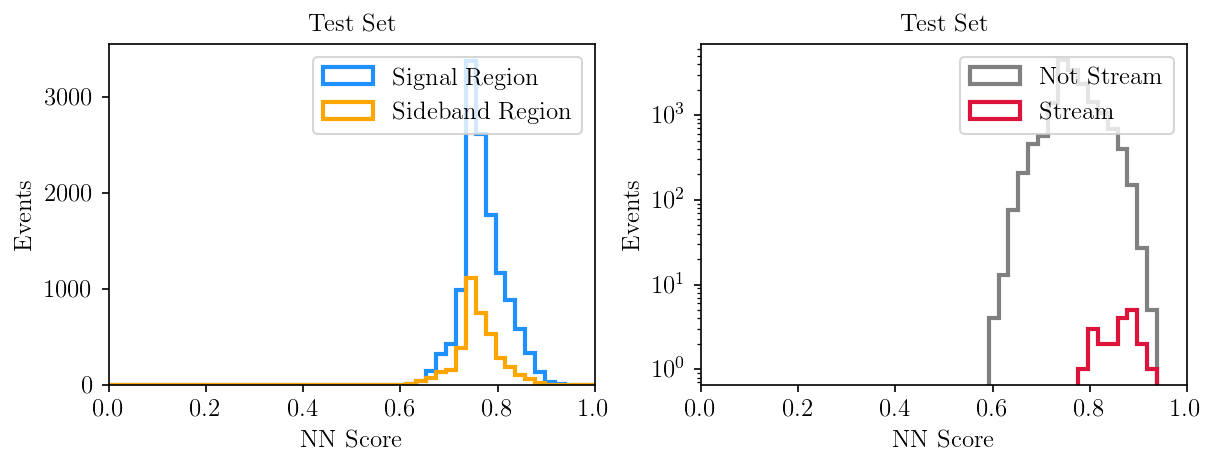

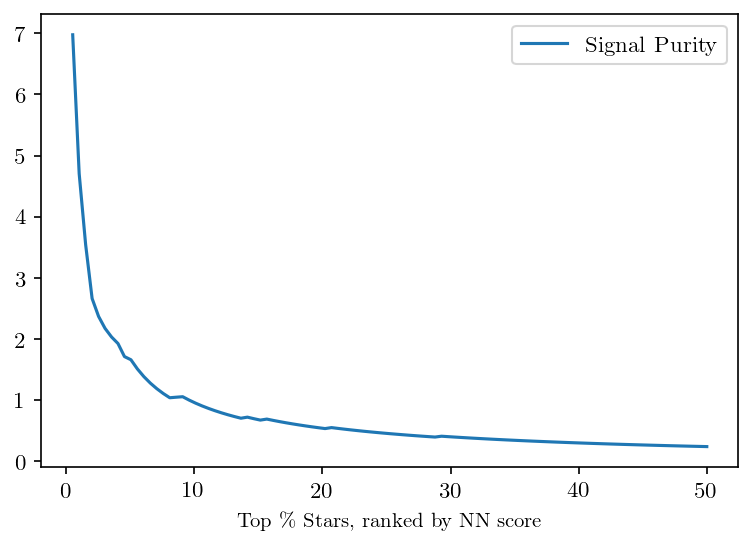

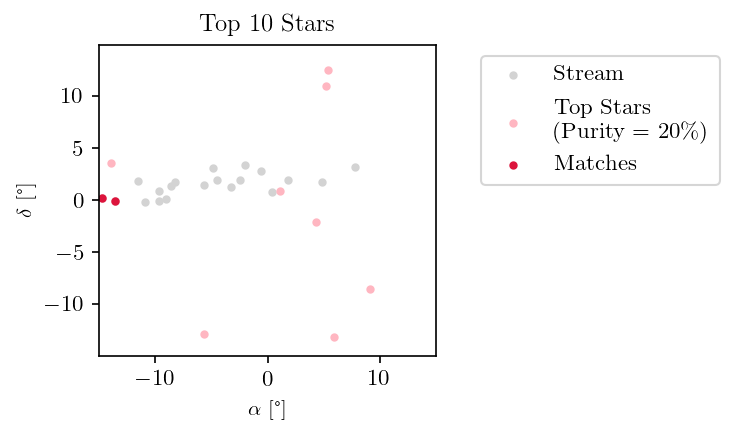

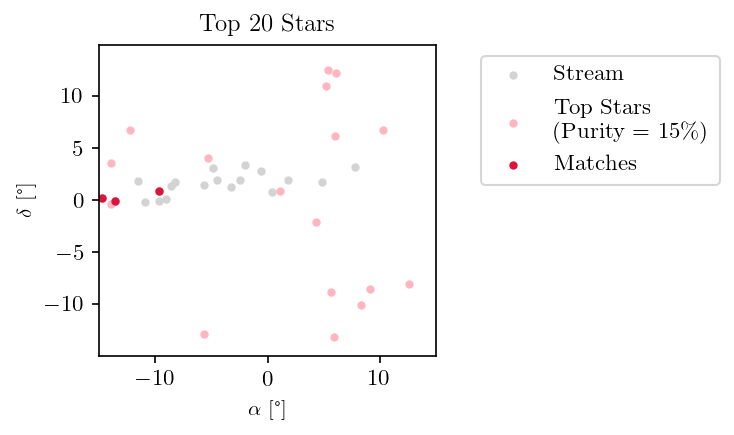

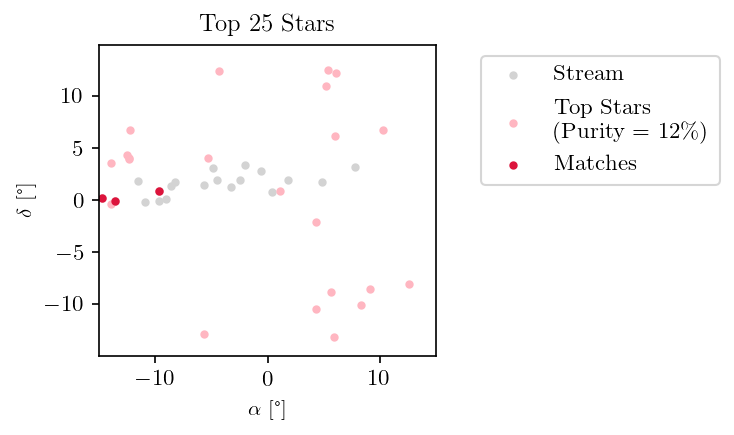

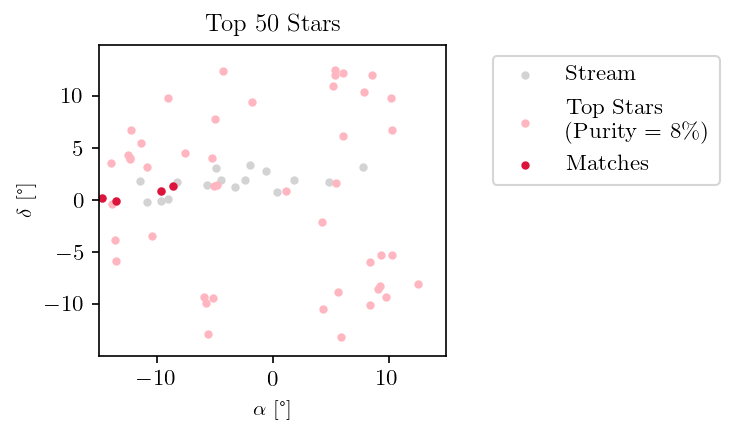

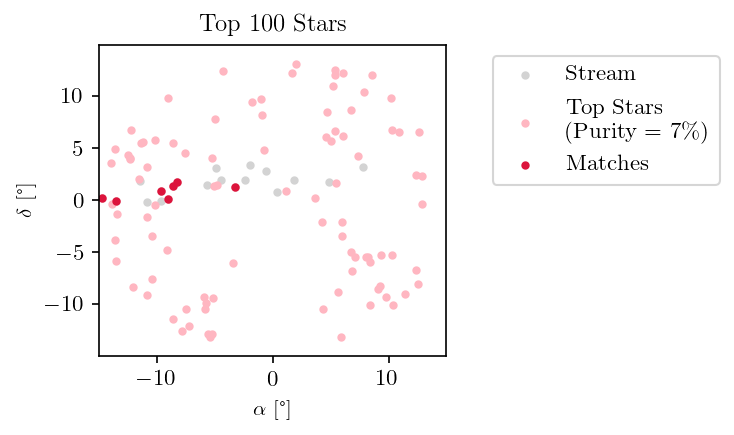

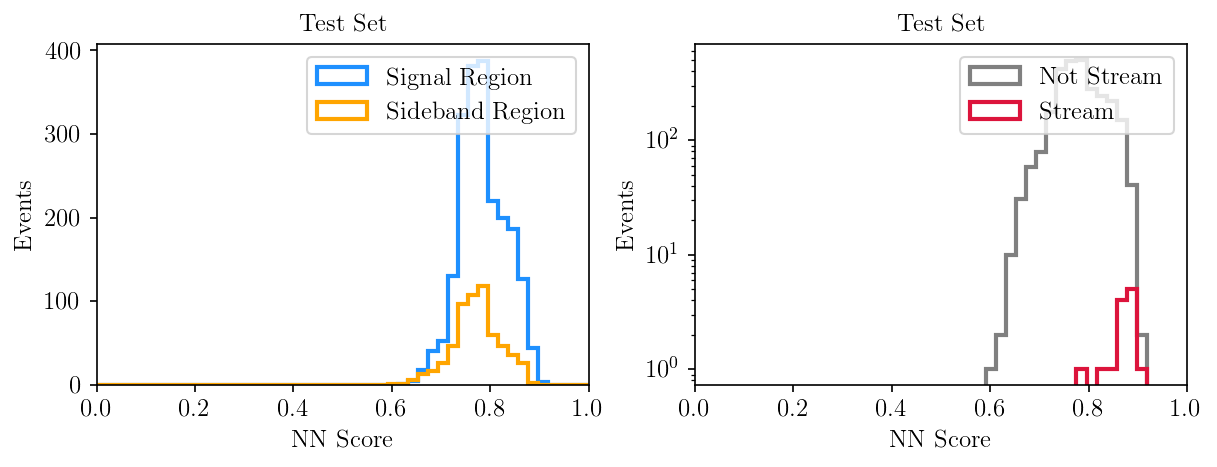

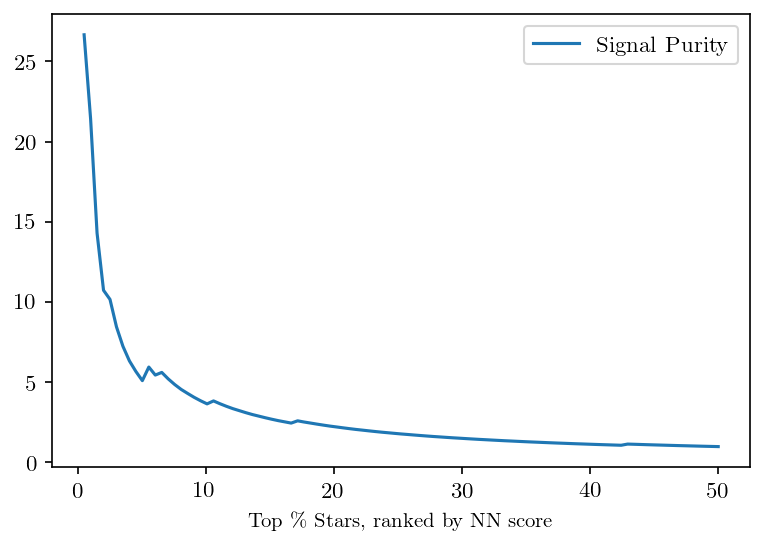

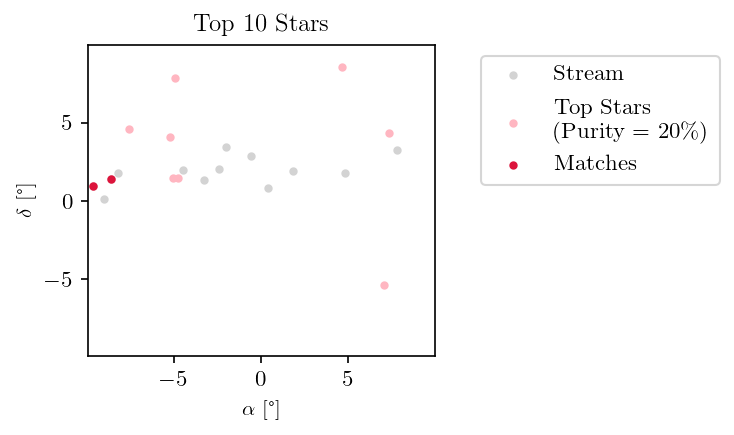

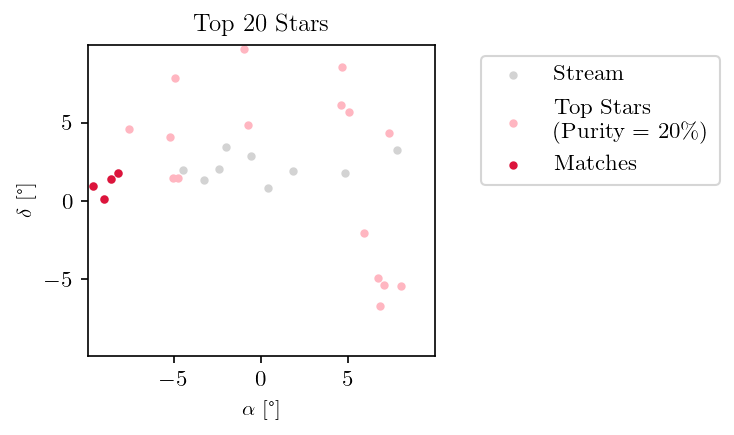

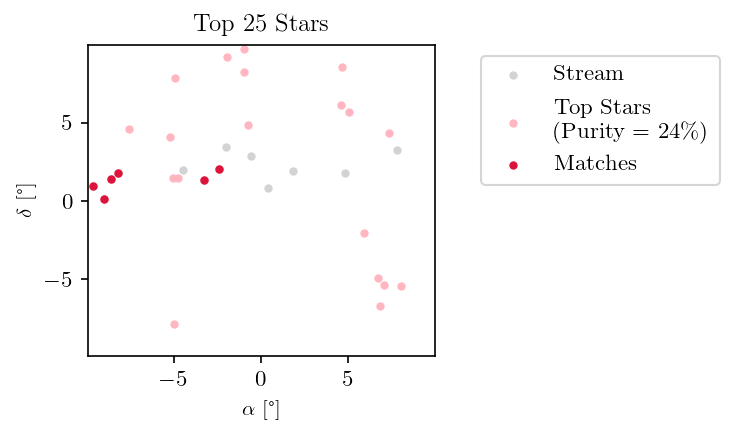

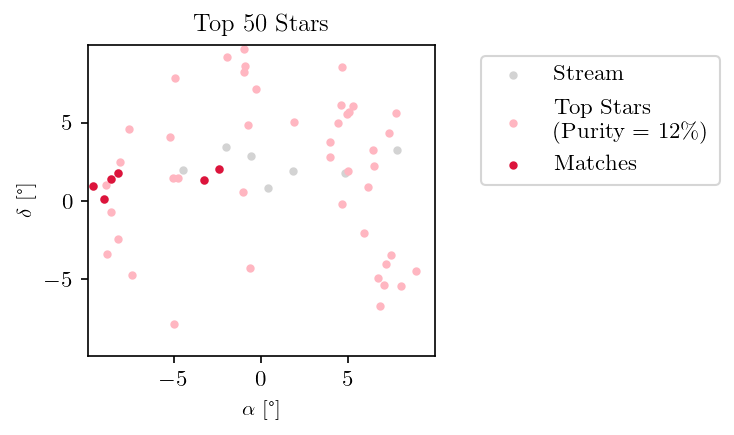

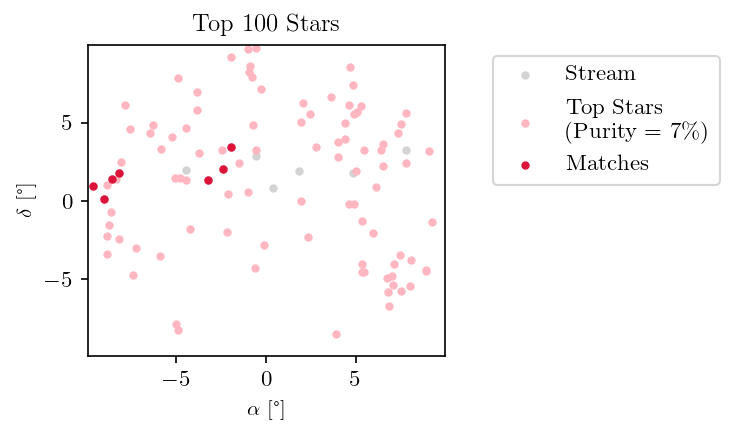

In [7]:
df_test = train(df, 
      n_folds = 10, 
      best_of_n_loops = 1,
      layer_size = 256, 
      batch_size = 1000, 
      dropout = 0.2, 
      epochs = 100, 
      l2_reg = 0,
      patience = 30,
      verbose = True,
      save_folder = save_folder, 
      other_callbacks=PlotLossesKeras(),
                        )

In [ ]:
# df_test = pd.read_hdf("re_found_gd1_tail/kfold_1/df_test.h5")
df_test = pd.read_hdf(save_folder+"before_fiducial_cuts/df_test.h5")
plot_results(fiducial_cuts(df_test), 
             save_folder = save_folder+"after_fiducial_cuts"
            )

# Remake plot...

In [ ]:
test = pd.read_hdf("../trained_models/foundtail_size128_batch10000_epochs2000_again/df_test.h5")

In [ ]:
test.α = test.α + 212.7
test.δ = test.δ + 55.2

In [ ]:
x = 50 
top_stars = test.sort_values('nn_score',ascending=False)[:x]
stream_stars_in_test_set = test[test.stream == True]
n_perfect_matches = top_stars.stream.value_counts()[True] 

In [ ]:
plt.figure(figsize=(5,3), dpi=150, tight_layout=True) 
plt.title('Top {} Stars'.format(x))
plt.scatter(stream_stars_in_test_set.α, stream_stars_in_test_set.δ, marker='.', 
        color = "lightgray",
        label='Stream')
plt.scatter(top_stars.α, top_stars.δ, marker='.', 
        color = "lightpink",
        label="Top Stars\n(Purity = {:.0f}\%)".format(n_perfect_matches/len(top_stars)*100))
if True in top_stars.stream.unique(): 
    plt.scatter(top_stars[top_stars.stream].α, top_stars[top_stars.stream].δ, marker='.', 
            color = "crimson",
            label='Matches')
plt.legend(bbox_to_anchor=(1.1, 1), loc='upper left')
plt.xlim(test.α.min(),test.α.max())
plt.ylim(test.δ.min(),test.δ.max())
plt.xlabel(r"$\alpha$ [\textdegree]")
plt.ylabel(r"$\delta$ [\textdegree]");
plt.savefig("top_50_stars_gd1_tail.pdf");